In [74]:
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv1D, Input, Dense, Dropout, GlobalMaxPooling1D, LayerNormalization, BatchNormalization, MaxPooling1D # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.metrics import BinaryAccuracy # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

FOLDER_FILTER = '../24h-ecg-normalized-filter/'
MODEL = "../model/"
FOLDER_STROKE_MODEL = "stroke-model/"
FOLDER_STROKE_MODEL_TUNING = "stroke_model_tuning/"
LABEL_FILE = "label.txt"
DATASET_STROKE = "../24h-ecg-quality"
DATASET_STROKE_UNQUALITY = "../24h-ecg-unquality"
METADATA = '../subjects.xlsx'

Num GPUs Available:  0


# Predict all rest dataset in FOLDER_FILTER

In [46]:
label_after_qc= os.path.join(FOLDER_FILTER, "label.txt")
loaded_model = load_model(os.path.join(MODEL, "qc_model.keras"))

with open(label_after_qc, 'w') as label_file:
    for file_name in os.listdir(FOLDER_FILTER):
        file_path = os.path.join(FOLDER_FILTER, file_name)
        
        if file_name.endswith('p_signal.txt'):
            with open(file_path, 'r') as signal_file:
                signal = np.loadtxt(signal_file)
                prediction = loaded_model.predict(np.expand_dims(signal, axis=0))
                label_file.write(f"{file_name} {prediction}\n")

print("Predictions complete and written to label.txt.")

ValueError: File not found: filepath=../model/qc_model.keras. Please ensure the file is an accessible `.keras` zip file.

# Copy all qualified datasets to QUALITY_DATASET

In [ ]:
folders = {
    True: DATASET_STROKE,
    False: DATASET_STROKE_UNQUALITY
}

with open(label_after_qc, 'r') as label_file:
    for line in label_file:
        file_name, label = line.strip().split()
        label = float(label.strip('[]'))
        
        source_file_path = os.path.join(FOLDER_FILTER, file_name)
        destination_folder = folders[label > 0.5]
        destination_file_path = os.path.join(destination_folder, file_name)
        
        shutil.copy2(source_file_path, destination_file_path)

print("Qualified segments have been moved to equivalent folder!")

Qualified segments have been moved to equivalent folder!


# Write label file from subject.xlsx

In [59]:
label_file = os.path.join(DATASET_STROKE, LABEL_FILE)
label_file_unquality = os.path.join(DATASET_STROKE_UNQUALITY, LABEL_FILE)

In [ ]:
label_file = os.path.join(DATASET_STROKE, LABEL_FILE)
label_file_unquality = os.path.join(DATASET_STROKE_UNQUALITY, LABEL_FILE)

if os.path.exists(label_file):
    os.remove(label_file)
    
if os.path.exists(label_file_unquality):
    os.remove(label_file_unquality)
    
def write_labels(dataset_path, label_file_path, metadata):
    with open(label_file_path, 'w') as f:
        for file_name in os.listdir(dataset_path):
            if file_name.endswith('_signal.txt'):
                patient_code = file_name.split('-')[0].upper()
                patient_data = metadata[metadata['subject_number'].str.upper() == patient_code]
                if not patient_data.empty:
                    patient_info = patient_data.iloc[0]
                    label_info = [
                        patient_info['GROUP'],
                        # patient_info['GROUP_TYPE'],
                        # patient_info['STROKE YR PATIENT MEDICAL HISTORY'],
                        patient_info['STROKE GROUP'],
                        # patient_info['STROKE SIDE'],
                        # patient_info['STROKE ETIOLOGY']
                    ]
                    f.write(f"{file_name} {' '.join(map(str, label_info))}\n")
                else:
                    print(file_name)

metadata = pd.read_excel(METADATA, sheet_name='subjects')
write_labels(DATASET_STROKE, label_file, metadata)
print("_________________")
write_labels(DATASET_STROKE_UNQUALITY, label_file_unquality, metadata)

print("Label files created successfully.")

s0268-06060109_44_p_signal.txt
s0268-06060109_11_p_signal.txt
s0268-06060109_43_p_signal.txt
s0268-06060109_16_p_signal.txt
s0268-06060109_8_p_signal.txt
s0268-06060109_56_p_signal.txt
s0268-06060109_51_p_signal.txt
s0268-06060109_67_p_signal.txt
s0268-06060109_32_p_signal.txt
s0268-06060109_98_p_signal.txt
s0268-06060109_60_p_signal.txt
s0268-06060109_35_p_signal.txt
s0268-06060109_75_p_signal.txt
s0268-06060109_20_p_signal.txt
s0268-06060109_72_p_signal.txt
s0268-06060109_27_p_signal.txt
s0268-06060109_50_p_signal.txt
s0268-06060109_57_p_signal.txt
s0268-06060109_17_p_signal.txt
s0268-06060109_10_p_signal.txt
s0268-06060109_45_p_signal.txt
s0268-06060109_9_p_signal.txt
s0268-06060109_26_p_signal.txt
s0268-06060109_73_p_signal.txt
s0268-06060109_21_p_signal.txt
s0268-06060109_74_p_signal.txt
s0268-06060109_100_p_signal.txt
s0268-06060109_34_p_signal.txt
s0268-06060109_61_p_signal.txt
s0268-06060109_99_p_signal.txt
s0268-06060109_33_p_signal.txt
s0268-06060109_66_p_signal.txt
s0268-060

# Load data

In [ ]:
input_dim = (6000, 5)

def load_data(data_folder, label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            filename = parts[0]
            label = list(map(float, parts[1:]))
            labels[filename] = label
    
    signals = []
    signal_labels = []
    for filename in os.listdir(data_folder):
        if filename.endswith('_signal.txt'):
            file_path = os.path.join(data_folder, filename)
            signal = np.loadtxt(file_path).reshape(input_dim)
            if filename in labels:
                signals.append(signal)
                signal_labels.append(labels[filename])
    
    return np.transpose(np.array(signals), (0, 2, 1)), np.array(signal_labels)

label_file = os.path.join(DATASET_STROKE, LABEL_FILE)
X, y = load_data(DATASET_STROKE, label_file)

In [ ]:
print(X.shape, y.shape)
for i in range(10):
    print(X[0][i], y[i])

(16619, 6000, 5) (16619, 2)
[ 3.69290573e-02  4.11215188e-02 -4.19246147e-03  5.25394991e-05
  3.10499791e-07] [0. 0.]
[ 2.91545190e-02  4.16469138e-02 -1.24923948e-02  5.56444970e-05
  4.74214794e-07] [0. 0.]
[ 2.52672498e-02  4.22344087e-02 -1.69671590e-02  6.20237950e-05
  6.53971971e-07] [0. 0.]
[ 2.42954325e-02  4.28873897e-02 -1.85919572e-02  6.87239364e-05
  6.84156079e-07] [1. 1.]
[ 2.52672498e-02  4.36088875e-02 -1.83416377e-02  7.57069166e-05
  7.10384661e-07] [1. 1.]
[ 2.62390671e-02  4.44015280e-02 -1.81624610e-02  8.29316296e-05
  7.32478487e-07] [1. 1.]
[ 2.72108844e-02  4.52675201e-02 -1.80566357e-02  9.03564863e-05
  7.50439954e-07] [0. 0.]
[ 2.91545190e-02  4.62086578e-02 -1.70541388e-02  9.79404287e-05
  7.64338057e-07] [0. 0.]
[ 3.01263362e-02  4.72263286e-02 -1.70999924e-02  1.05643247e-04
  7.74242038e-07] [1. 1.]
[ 3.10981535e-02  4.83215227e-02 -1.72233692e-02  1.13425269e-04
  7.80141246e-07] [0. 0.]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Tunning hyperparams for model

In [48]:

checkpoint_path = os.path.join(MODEL + FOLDER_STROKE_MODEL, "stroke_checkpoint.keras")
model_path = os.path.join(MODEL + FOLDER_STROKE_MODEL, "stroke_model.keras")

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

if os.path.exists(model_path):
    os.remove(model_path)
    
epochs = 50
batch_size = 32

def build_model(hp):
    model = Sequential()
    
    for i in range(hp.Int('conv_layers', 1, 3)):
        if i == 0:
            model.add(Conv1D(
                filters=hp.Int(f'filters_{i}', min_value=16, max_value=64, step=4),
                kernel_size=hp.Int(f'kernel_size_{i}', min_value=10, max_value=30, step=1),
                strides=hp.Int(f'strides_{i}', min_value=1, max_value=3, step=1),
                activation='relu',
                input_shape=input_dim
            ))
        else:
            model.add(Conv1D(
                filters=hp.Int(f'filters_{i}', min_value=16, max_value=64, step=4),
                kernel_size=hp.Int(f'kernel_size_{i}', min_value=10, max_value=30, step=1),
                strides=hp.Int(f'strides_{i}', min_value=1, max_value=3, step=1),
                activation='relu'
            ))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout', 0.2, 0.7, step=0.25)))
    
    model.add(GlobalMaxPooling1D())
    
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(rate=hp.Float('dense_dropout', 0.1, 0.7, step=0.25)))
    
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy()]
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory=MODEL,
    project_name='stroke_model_tuning'
)

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

tuner.search(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size, callbacks=callbacks)

best_model = tuner.get_best_models(num_models=1)[0]

score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

best_model.save(model_path)

Reloading Tuner from ../model/stroke_model_tuning/tuner0.json
Test loss: 0.9437925815582275
Test accuracy: 0.4780385196208954


# Get best trial with loss > 0

In [54]:
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

positive_loss_trials = []
for trial in trials:
    val_loss = trial.metrics.get_last_value("val_loss")
    if val_loss and val_loss > 0:
        positive_loss_trials.append((trial, val_loss))


positive_loss_trials.sort(key=lambda x: x[1])

if positive_loss_trials:
    best_trial = positive_loss_trials[0][0]
    best_model = tuner.hypermodel.build(best_trial.hyperparameters)
    best_model.fit(X_train, y_train, epochs=best_trial.hyperparameters.get('tuner/epochs'),
                   validation_data=(X_val, y_val), batch_size=batch_size, callbacks=callbacks)
else:
    print("No valid trials with positive loss found.")

score = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

best_model.save(model_path)

Epoch 1/17
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - binary_accuracy: 0.5122 - loss: 1.0137
Epoch 1: val_loss improved from inf to 0.72637, saving model to ../model/stroke-model/stroke_checkpoint.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 108s 311ms/step - binary_accuracy: 0.5122 - loss: 1.0133 - val_binary_accuracy: 0.5557 - val_loss: 0.7264 - learning_rate: 5.0776e-04
Epoch 2/17
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - binary_accuracy: 0.5735 - loss: 0.6982
Epoch 2: val_loss improved from 0.72637 to 0.64411, saving model to ../model/stroke-model/stroke_checkpoint.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 95s 284ms/step - binary_accuracy: 0.5735 - loss: 0.6981 - val_binary_accuracy: 0.6587 - val_loss: 0.6441 - learning_rate: 5.0776e-04
Epoch 3/17
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - binary_accuracy: 0.6378 - loss: 0.6229
Epoch 3: val_loss improved from 0.64411 to 0.61046, saving model to ../model/stroke-model/stroke_checkpoint.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 79s 237ms/step - binary

In [70]:
conv_layers = best_trial.hyperparameters.get('conv_layers')
filters_0 = best_trial.hyperparameters.get('filters_0')
kernel_size_0 = best_trial.hyperparameters.get('kernel_size_0')
strides_0 = best_trial.hyperparameters.get('strides_0')
dropout = best_trial.hyperparameters.get('dropout')
dense_dropout = best_trial.hyperparameters.get('dense_dropout')
learning_rate = best_trial.hyperparameters.get('learning_rate')
filters_1 = best_trial.hyperparameters.get('filters_1')
kernel_size_1 = best_trial.hyperparameters.get('kernel_size_1')
strides_1 = best_trial.hyperparameters.get('strides_1')
filters_2 = best_trial.hyperparameters.get('filters_2')
kernel_size_2 = best_trial.hyperparameters.get('kernel_size_2')
strides_2 = best_trial.hyperparameters.get('strides_2')
epochs=best_trial.hyperparameters.get('tuner/epochs')

print(f'conv_layers: {conv_layers}')
print(f'filters_0: {filters_0}')
print(f'kernel_size_0: {kernel_size_0}')
print(f'strides_0: {strides_0}')
print(f'dropout: {dropout}')
print(f'dense_dropout: {dense_dropout}')
print(f'learning_rate: {learning_rate}')
print(f'filters_1: {filters_1}')
print(f'kernel_size_1: {kernel_size_1}')
print(f'strides_1: {strides_1}')
print(f'filters_2: {filters_2}')
print(f'kernel_size_2: {kernel_size_2}')
print(f'strides_2: {strides_2}')


conv_layers: 2
filters_0: 20
kernel_size_0: 15
strides_0: 1
dropout: 0.2
dense_dropout: 0.6
learning_rate: 0.0005077584365195038
filters_1: 32
kernel_size_1: 30
strides_1: 2
filters_2: 48
kernel_size_2: 23
strides_2: 2


# Building Stroke Model

In [73]:
checkpoint_path = os.path.join(MODEL + FOLDER_STROKE_MODEL, "stroke_checkpoint.keras")
model_path = os.path.join(MODEL + FOLDER_STROKE_MODEL, "stroke_model.keras")

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

if os.path.exists(model_path):
    os.remove(model_path)
    
batch_size = 32
input_dim = (6000, 5)

def build_model():
    model = Sequential()
    
    for i in range(conv_layers):
        if i == 0:
            model.add(Conv1D(
                filters=filters_0,
                kernel_size=kernel_size_0,
                strides=strides_0,
                activation='relu',
                input_shape=input_dim
            ))
        elif i == 1:
            model.add(Conv1D(
                filters=filters_1,
                kernel_size=kernel_size_1,
                strides=strides_1,
                activation='relu'
            ))
        elif i == 2:
            model.add(Conv1D(
                filters=filters_2,
                kernel_size=kernel_size_2,
                strides=strides_2,
                activation='relu'
            ))
        
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=dropout))
    
    model.add(GlobalMaxPooling1D())
    
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(rate=dense_dropout))
    
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy()]
    )
    return model

model = build_model()

# Define callbacks
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

# Train the model
history = model.fit(X_train, y_train, epochs=epochs+1, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

# Save the trained model
model.save(model_path)

Epoch 1/18
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - binary_accuracy: 0.5141 - loss: 1.0047
Epoch 1: val_loss improved from inf to 0.72668, saving model to ../model/stroke-model/stroke_checkpoint.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 98s 284ms/step - binary_accuracy: 0.5141 - loss: 1.0043 - val_binary_accuracy: 0.5481 - val_loss: 0.7267 - learning_rate: 5.0776e-04
Epoch 2/18
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - binary_accuracy: 0.5493 - loss: 0.7023
Epoch 2: val_loss improved from 0.72668 to 0.66136, saving model to ../model/stroke-model/stroke_checkpoint.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 89s 268ms/step - binary_accuracy: 0.5494 - loss: 0.7023 - val_binary_accuracy: 0.6158 - val_loss: 0.6614 - learning_rate: 5.0776e-04
Epoch 3/18
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - binary_accuracy: 0.6177 - loss: 0.6461
Epoch 3: val_loss improved from 0.66136 to 0.61506, saving model to ../model/stroke-model/stroke_checkpoint.keras
333/333 ━━━━━━━━━━━━━━━━━━━━ 89s 268ms/step - binary_

tuning
Test loss: 10.71%
Test accuracy: 77.41%
manual
Test loss: 20.87%
Test accuracy: 77.36%


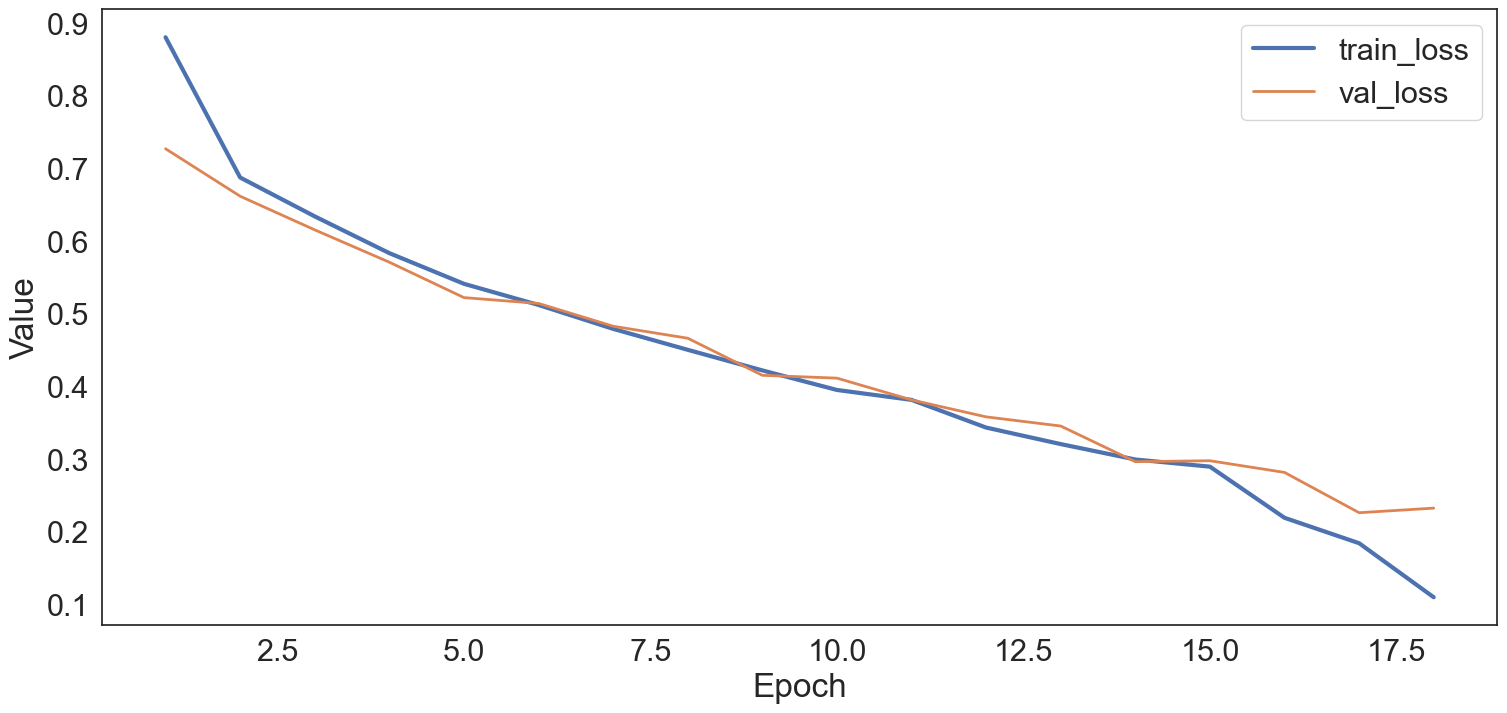

In [75]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print("tuning")
print(f"Test loss: {score[0] * 100:.2f}%")
print(f"Test accuracy: {score[1] * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("manual")
print(f'Test loss: {test_loss * 100:.2f}%')
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 8))
sns.set(font_scale=2)
sns.set_style("white")

plt.plot(range(1, len(train_loss) + 1), train_loss, label='train_loss', linewidth=3.0)
plt.plot(range(1, len(val_loss) + 1), val_loss, label='val_loss', linewidth=2.0)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [77]:
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

if os.path.exists(model_path):
    os.remove(model_path)
    
best_model.save(model_path)

In [78]:
best_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 5986, 20)       │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 2993, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2993, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1482, 32)       │        19,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 741, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 741, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,704 (295.72 KB)

 Trainable params: 25,234 (98.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,470 (197.15 KB)

333/333 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step
Shapes:
train_predict: (10636, 2), y_train: (21272, 1)
test_predict: (3324, 2), y_test: (6648, 1)
After inverse transform:
train_predict: (21272, 1), train_true: (21272, 1)
test_predict: (6648, 1), test_true: (6648, 1)
Train MSE: 1.65157431227279
Test MSE: 1.7278096521319697
____________________
Train MAE: 0.9737973991107587
Test MAE: 1.0009011086592032
____________________
Train MAPE: 0.7075142965957119
Test MAPE: 0.7282180694038346
____________________
Train RMSE: 1.2851359119847168
Test RMSE: 1.3144617347538001
____________________
Train RMSPE: [0.94144588]
Test RMSPE: [0.96306018]


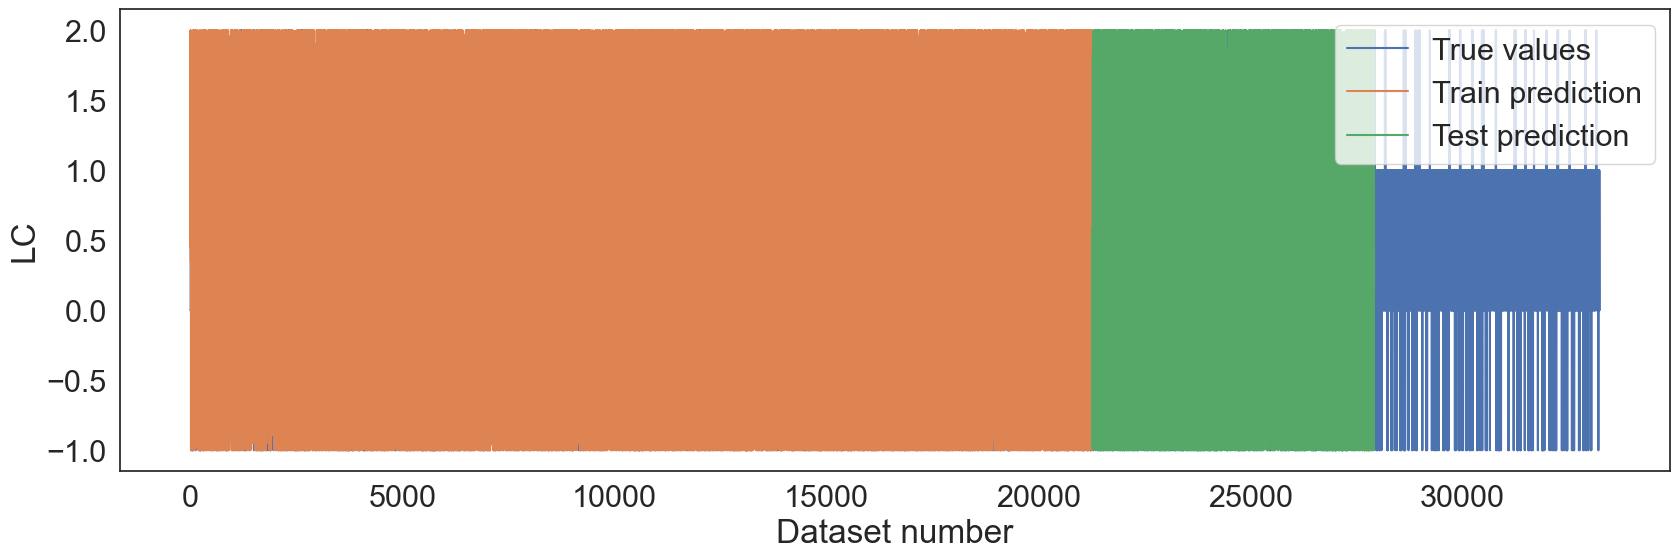

In [84]:
model = load_model(model_path)

# Predict on training and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Check the shapes of predictions and true values
print("Shapes:")
print(f"train_predict: {train_predict.shape}, y_train: {y_train.shape}")
print(f"test_predict: {test_predict.shape}, y_test: {y_test.shape}")

train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Scaling and inverse scaling
scaler = MinMaxScaler()
scaler.fit(y.reshape(-1, 1))

train_predict = scaler.inverse_transform(train_predict)
train_true = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_true = scaler.inverse_transform(y_test)

print("After inverse transform:")
print(f"train_predict: {train_predict.shape}, train_true: {train_true.shape}")
print(f"test_predict: {test_predict.shape}, test_true: {test_true.shape}")

# Calculate error metrics
train_mae = mean_absolute_error(train_true, train_predict)
test_mae = mean_absolute_error(test_true, test_predict)
train_mape = mean_absolute_percentage_error(train_true, train_predict)
test_mape = mean_absolute_percentage_error(test_true, test_predict)
train_mse = mean_squared_error(train_true, train_predict)
test_mse = mean_squared_error(test_true, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Avoid division by zero for RMSPE calculation
epsilon = np.finfo(float).eps
train_true_safe = np.where(train_true == 0, epsilon, train_true)
test_true_safe = np.where(test_true == 0, epsilon, test_true)
train_rmspe = np.sqrt(np.mean(np.square((train_true - train_predict) / train_true_safe), axis=0))
test_rmspe = np.sqrt(np.mean(np.square((test_true - test_predict) / test_true_safe), axis=0))

# Print error metrics
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print("____________________")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print("____________________")
print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")
print("____________________")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print("____________________")
print(f"Train RMSPE: {train_rmspe}")
print(f"Test RMSPE: {test_rmspe}")

# Prepare data for plotting
train_predict_plot = np.empty_like(y.reshape(-1, 1))
train_predict_plot[:, :] = np.nan
train_predict_plot[:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(y.reshape(-1, 1))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict):len(train_predict) + len(test_predict), :] = test_predict

true_values = y.reshape(-1, 1)

# Plot the results
plt.figure(figsize=(20, 6))
plt.xlabel("Dataset number")
plt.ylabel("LC")
plt.plot(true_values, label="True values")
plt.plot(train_predict_plot, label="Train prediction")
plt.plot(test_predict_plot, label="Test prediction")
plt.legend()
plt.show()